In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_original = pd.read_csv('data/train.csv')

In [3]:
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
df_original

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [5]:
df_original.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFramePreprocessor(BaseEstimator, TransformerMixin):
  def __init__(self):
    pass

  def fit(self, X, y=None):
    return self

  def transform(self, X, y=None):
    df = X.copy()

    # fill the missing Embarked
    df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])

    # Extract deck letter from Cabin (e.g., 'C85' → 'C')
    df['Cabin_letter'] = df['Cabin'].str[0]
    # Replace NaNs with a placeholder (e.g., 'U' for Unknown)
    df['Cabin_letter'] = df['Cabin_letter'].fillna('U')

    # we do not need the Cabin
    df.drop('Cabin', axis=1, inplace=True)

    # Extract title using regex
    df['Title'] = df['Name'].str.extract(r',\s*([^\.]+)\.', expand=False)

    title_mapping = {
        'Mr': 'Mr',
        'Miss': 'Miss',
        'Mrs': 'Mrs',
        'Master': 'Master',
        'Dr': 'Officer',
        'Rev': 'Officer',
        'Col': 'Officer',
        'Major': 'Officer',
        'Capt': 'Officer',
        'Mlle': 'Miss',
        'Ms': 'Miss',
        'Mme': 'Mrs',
        'Don': 'Royalty',
        'Dona': 'Royalty',
        'Sir': 'Royalty',
        'Lady': 'Royalty',
        'Countess': 'Royalty',
        'Jonkheer': 'Royalty'
    }

    df['Title'] = df['Title'].map(title_mapping)
    df['Title'] = df['Title'].fillna('Unknown')



    # Fill missing values in Age
    df['Age'] = df.groupby('Title')['Age'].transform(lambda x: x.fillna(x.median()))



    # People with small families had better chances to survive!
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1

    # Lone travelers were less likely to survive
    df['IsAlone'] = (df['FamilySize'] == 1).astype(int)

    # Extract prefix (letters only), fill missing ones
    df['TicketPrefix'] = df['Ticket'].str.extract(r'([A-Za-z]+)', expand=False)
    df['TicketPrefix'] = df['TicketPrefix'].fillna('Numeric')

    df['TicketCount'] = df.groupby('Ticket')['Ticket'].transform('count')
    df['IsSharedTicket'] = (df['TicketCount'] > 1).astype(int)


    return df

In [7]:
df = DataFramePreprocessor().fit_transform(df_original)

In [8]:
df[['Ticket', 'TicketPrefix', 'TicketCount', 'IsSharedTicket']]

,Ticket,TicketPrefix,TicketCount,IsSharedTicket
0,A/5 21171,A,1,0
1,PC 17599,PC,1,0
2,STON/O2. 3101282,STON,1,0
3,113803,Numeric,2,1
4,373450,Numeric,1,0
...,...,...,...,...
886,211536,Numeric,1,0
887,112053,Numeric,1,0
888,W./C. 6607,W,2,1
889,111369,Numeric,1,0


In [9]:
df.groupby('TicketPrefix')['Survived'].mean().sort_values(ascending=False)


TicketPrefix
SW         1.000000
SO         1.000000
PP         0.666667
F          0.666667
PC         0.650000
SC         0.538462
P          0.500000
WE         0.500000
C          0.454545
STON       0.444444
Numeric    0.384266
LINE       0.250000
S          0.142857
SOTON      0.117647
W          0.090909
CA         0.071429
A          0.068966
SCO        0.000000
Fa         0.000000
Name: Survived, dtype: float64

In [10]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize,IsAlone,TicketCount,IsSharedTicket
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.394130,0.523008,0.381594,32.204208,1.904602,0.602694,1.787879,0.386083
std,257.353842,0.486592,0.836071,13.270911,1.102743,0.806057,49.693429,1.613459,0.489615,1.361142,0.487123
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
25%,223.500000,0.000000,2.000000,21.000000,0.000000,0.000000,7.910400,1.000000,0.000000,1.000000,0.000000
50%,446.000000,0.000000,3.000000,30.000000,0.000000,0.000000,14.454200,1.000000,1.000000,1.000000,0.000000
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000,2.000000,1.000000,2.000000,1.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,11.000000,1.000000,7.000000,1.000000


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   PassengerId     891 non-null    int64  
 1   Survived        891 non-null    int64  
 2   Pclass          891 non-null    int64  
 3   Name            891 non-null    object 
 4   Sex             891 non-null    object 
 5   Age             891 non-null    float64
 6   SibSp           891 non-null    int64  
 7   Parch           891 non-null    int64  
 8   Ticket          891 non-null    object 
 9   Fare            891 non-null    float64
 10  Embarked        891 non-null    object 
 11  Cabin_letter    891 non-null    object 
 12  Title           891 non-null    object 
 13  FamilySize      891 non-null    int64  
 14  IsAlone         891 non-null    int64  
 15  TicketPrefix    891 non-null    object 
 16  TicketCount     891 non-null    int64  
 17  IsSharedTicket  891 non-null    int

## Histogram for each attribute

/Users/nick/miniconda3/envs/ml/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/nick/miniconda3/envs/ml/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/nick/miniconda3/envs/ml/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/nick/miniconda3/envs/ml/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be rem

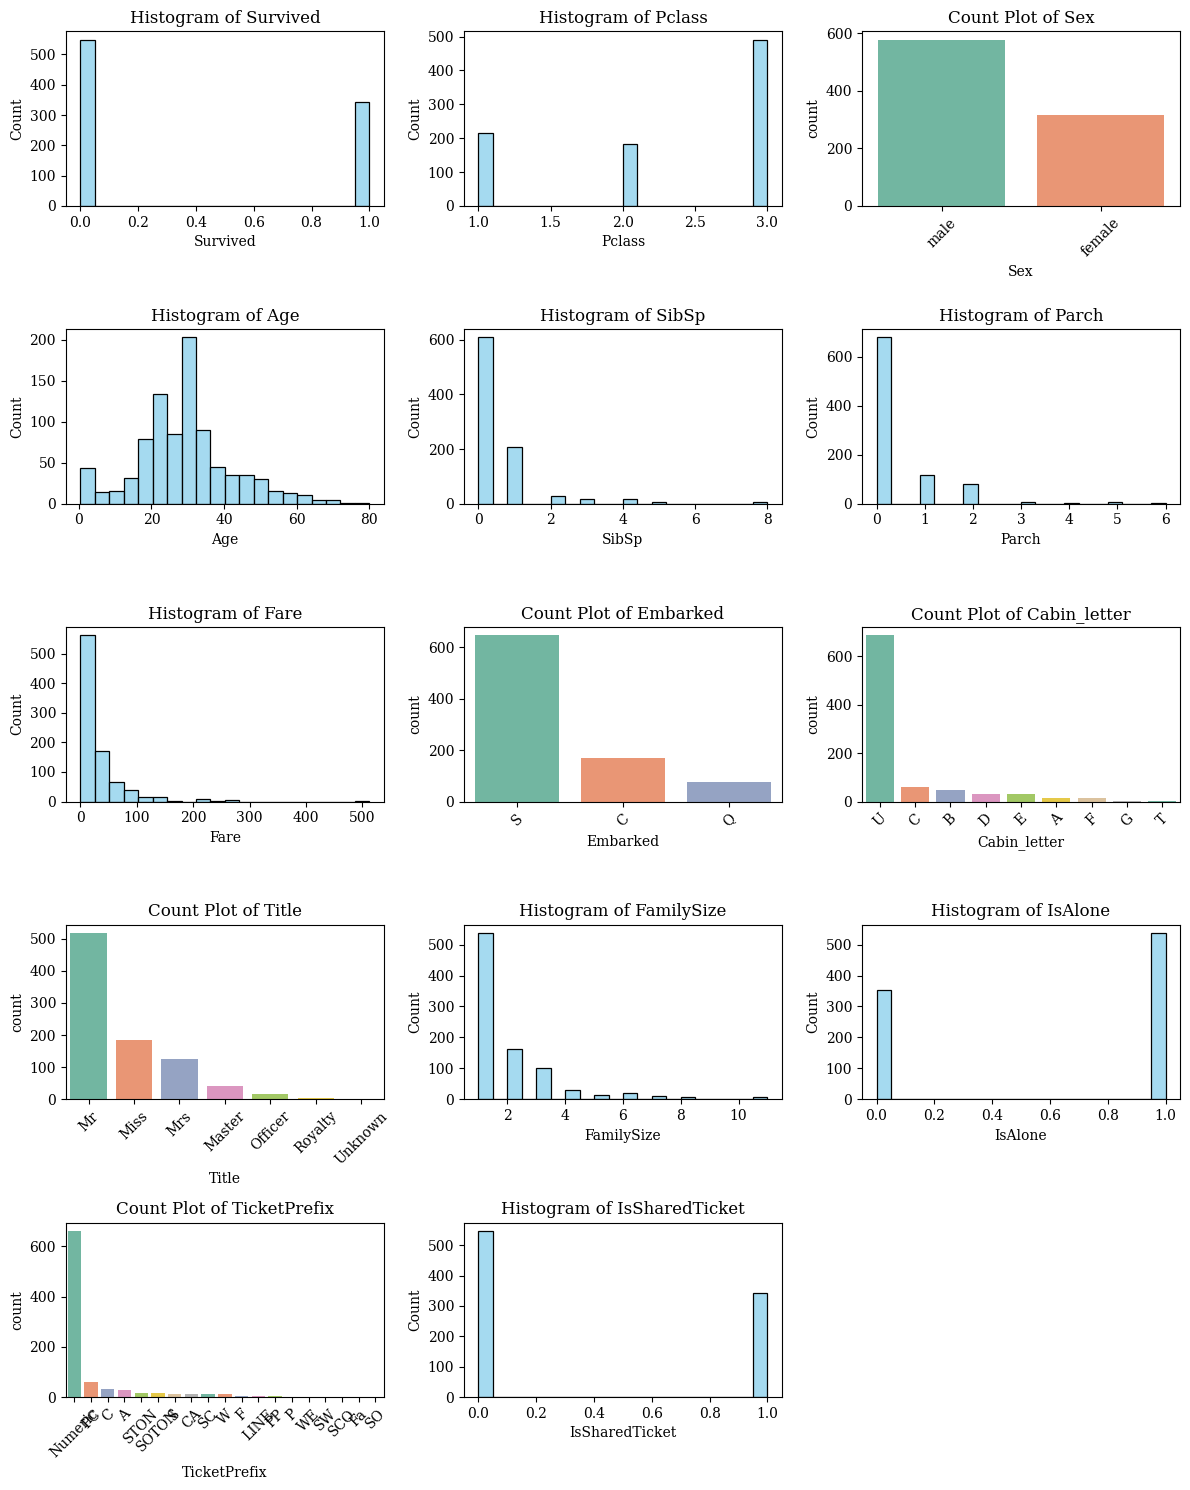

In [12]:
df = DataFramePreprocessor().fit_transform(df_original)

# Set number of plots per row
list_of_attributes = ['Survived', 'Pclass', 'Sex', 'Age', 'SibSp',  'Parch',
                      'Fare', 'Embarked', 'Cabin_letter', 'Title',
                      'FamilySize', 'IsAlone', 'TicketPrefix',
                      'IsSharedTicket'
                      ]
n_cols = 3
n_plots = len(list_of_attributes)
n_rows = (n_plots + n_cols - 1) // n_cols

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows))
axes = axes.flatten()


for i, col in enumerate(list_of_attributes):
    ax = axes[i]
    if df[col].dtype in ['int64', 'float64']:   # this is a numeric attribute
        sns.histplot(df[col].dropna(), bins=20, ax=ax, kde=False, color='skyblue')
        ax.set_title(f"Histogram of {col}")
    else:
        sns.countplot(data=df, x=col, ax=ax, palette='Set2',
                      order=df[col].value_counts().index)
        ax.set_title(f"Count Plot of {col}")
        ax.tick_params(axis='x', rotation=45)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [13]:
df.isnull().sum()[df.isnull().sum() > 0]

Series([], dtype: int64)

In [14]:
seri = df.groupby(by='Embarked')['Survived'].mean()
seri


Embarked
C    0.553571
Q    0.389610
S    0.339009
Name: Survived, dtype: float64

## Correlations

<Axes: >

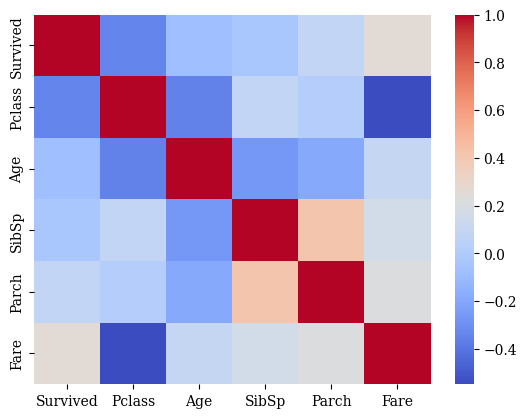

In [15]:
list_of_attributes = ['Survived', 'Pclass', 'Age', 'SibSp',  'Parch', 'Fare', ]

corr = df[list_of_attributes].corr()
sns.heatmap(corr, cmap = 'coolwarm', annot=False)

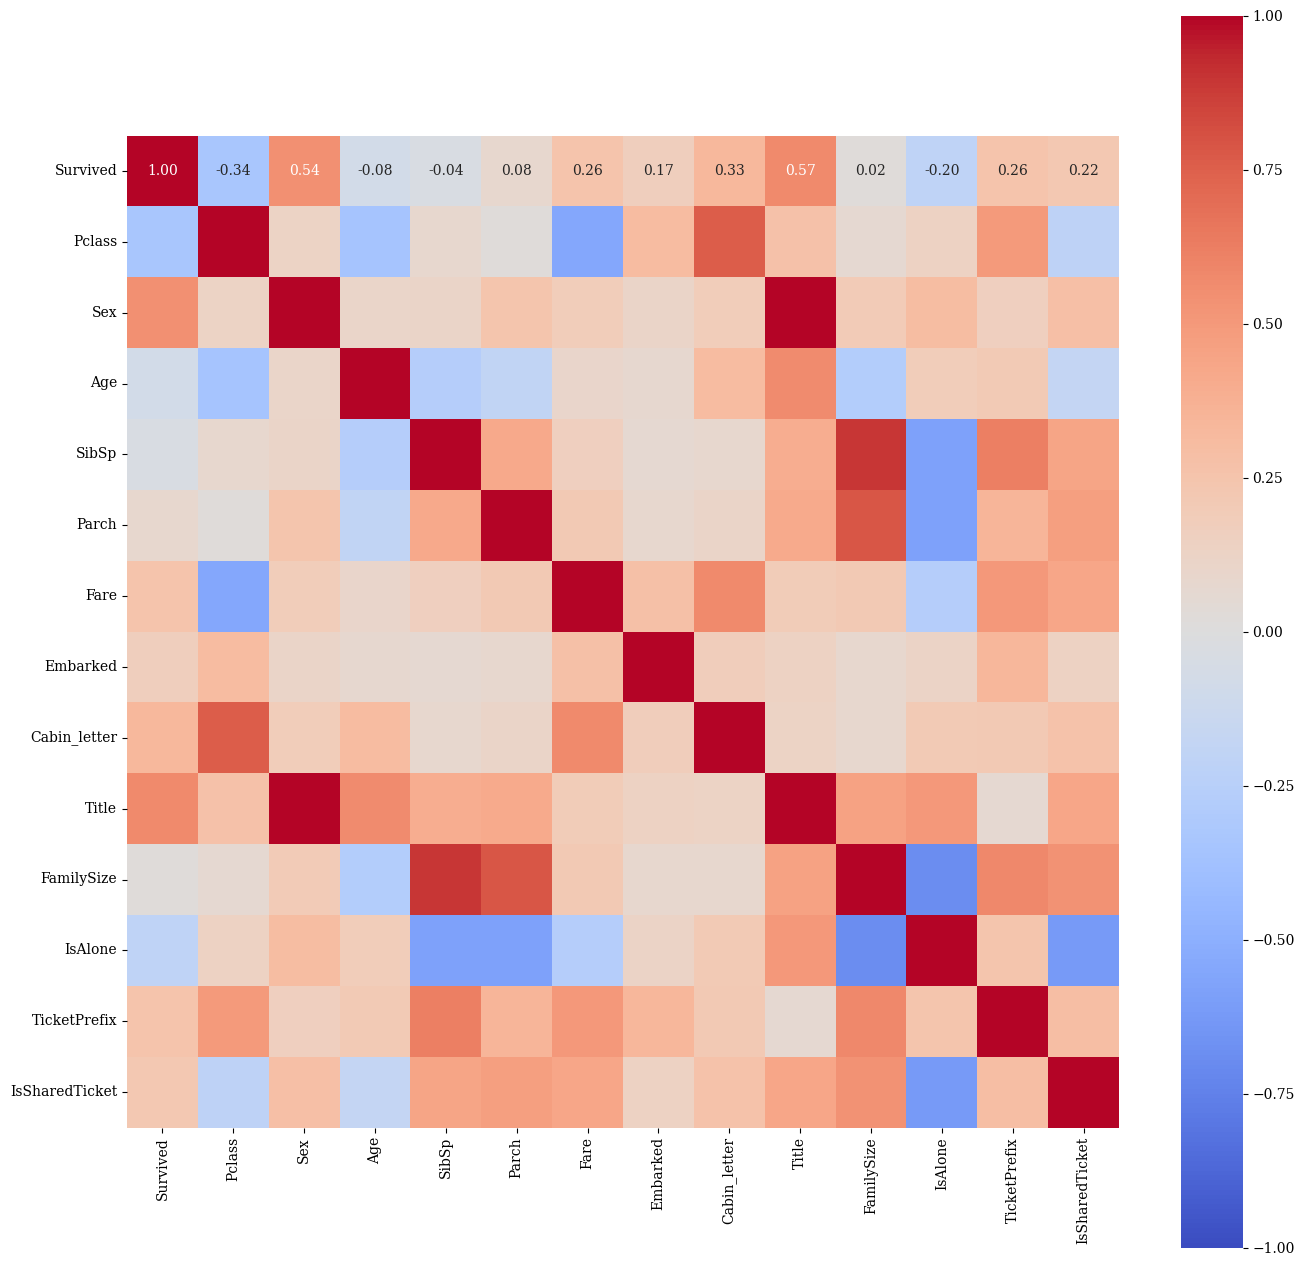

Correlation with Survived attribute:
Survived          1.000000
Title             0.571176
Sex               0.543351
Cabin_letter      0.333610
Fare              0.257307
TicketPrefix      0.256786
IsSharedTicket    0.222602
Embarked          0.170707
Parch             0.081629
FamilySize        0.016639
SibSp            -0.035322
Age              -0.079016
IsAlone          -0.203367
Pclass           -0.338481
Name: Survived, dtype: float64


In [16]:
list_of_attributes = ['Survived', 'Pclass', 'Sex', 'Age', 'SibSp',  'Parch',
                      'Fare', 'Embarked', 'Cabin_letter', 'Title',
                      'FamilySize', 'IsAlone', 'TicketPrefix',
                      'IsSharedTicket'
                      ]

try:
    from dython.nominal import associations
    assoc = associations(df[list_of_attributes], figsize=(16, 16), cmap = 'coolwarm')
    print("Correlation with Survived attribute:")
    print(assoc['corr']['Survived'].sort_values(ascending=False))
except ModuleNotFoundError:
    print("module 'dython' is not installed")

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   PassengerId     891 non-null    int64  
 1   Survived        891 non-null    int64  
 2   Pclass          891 non-null    int64  
 3   Name            891 non-null    object 
 4   Sex             891 non-null    object 
 5   Age             891 non-null    float64
 6   SibSp           891 non-null    int64  
 7   Parch           891 non-null    int64  
 8   Ticket          891 non-null    object 
 9   Fare            891 non-null    float64
 10  Embarked        891 non-null    object 
 11  Cabin_letter    891 non-null    object 
 12  Title           891 non-null    object 
 13  FamilySize      891 non-null    int64  
 14  IsAlone         891 non-null    int64  
 15  TicketPrefix    891 non-null    object 
 16  TicketCount     891 non-null    int64  
 17  IsSharedTicket  891 non-null    int

## Preparing Training and Test sets

In [18]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

/Users/nick/miniconda3/envs/ml/lib/python3.12/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:15: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


In [19]:
def get_features_piplines(numeric_features, categorical_features):

    numeric_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    # Categorical pipeline
    categorical_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    # Combine pipelines using ColumnTransformer
    columns_transformer = ColumnTransformer([
        ('num', numeric_pipeline, numeric_features),
        ('cat', categorical_pipeline, categorical_features)
    ])

    features_pipline = Pipeline([
        ('df_preprocess', DataFramePreprocessor()),
        ('columns', columns_transformer)
    ])

    return features_pipline

## Evaluate Multiple Models

In [21]:
def learning_cuvre_plot(model, X, y, ax=None, title=None):

    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y,
        train_sizes=np.linspace(0.1, 1, 10),
        cv=5,
        scoring='accuracy',
        n_jobs=-1,
        )
    if ax:
        train_scores_mean = train_scores.mean(axis=1)
        val_scores_mean = val_scores.mean(axis=1)

        ax.plot(train_sizes, train_scores_mean, label='Training Accuracy', 
                marker='o', lw=1, markersize=4)
        ax.plot(train_sizes, val_scores_mean, label='Validation Accuracy', 
                marker='s', lw=1, markersize=4)
        ax.set_xlabel('Training Set Size')
        ax.set_ylabel('Accuracy')
        ax.set_title(f'Learning Curve - {title}')
        ax.legend()
        ax.grid(True)


In [22]:
numeric_features = ['Age', 'SibSp', 'Parch', 'Fare', 'FamilySize']
categorical_features = ['Pclass', 'Sex', 'Embarked', 'Cabin_letter', 'Title',
                        'IsAlone', 'TicketPrefix', 'IsSharedTicket']


Training Logistic...
Training Ridge_0.2...
Training Ridge_1...
Training Lasso_5...
Training Lasso_1...


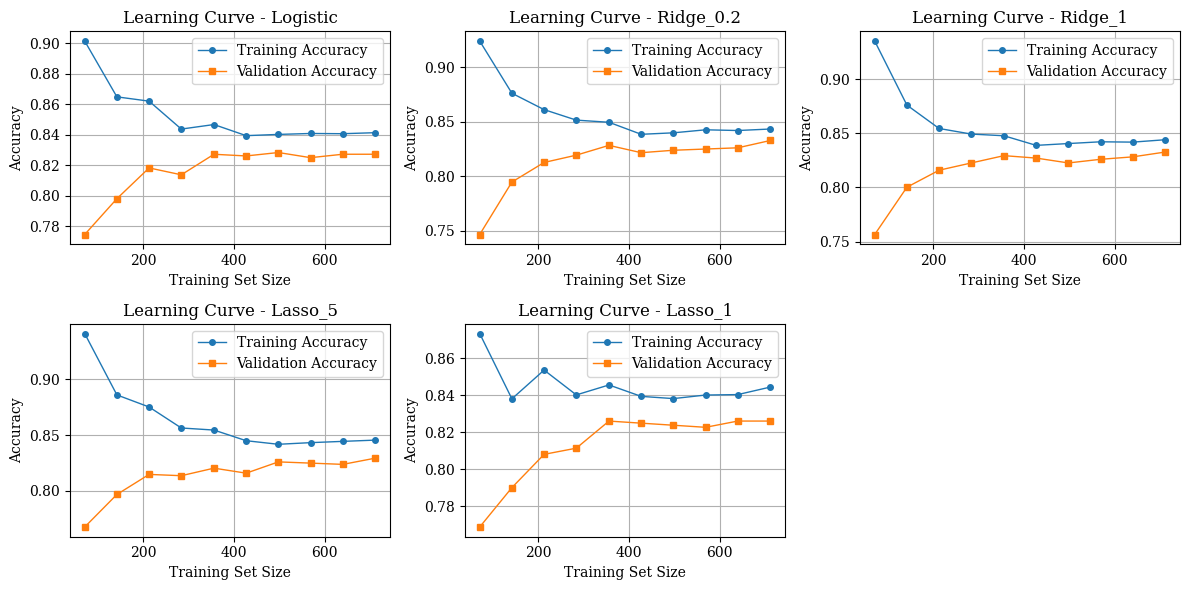

In [23]:
features_pipline = get_features_piplines(numeric_features, categorical_features)

X = features_pipline.fit_transform(df_original)
y = df['Survived']

models = [('Logistic', LogisticRegression()),]

for alpha in [0.2, 1,]:
    models.append((f'Ridge_{alpha}', RidgeClassifier(alpha=alpha)))

for C in [5, 1]:
    models.append((f'Lasso_{C}', LogisticRegression(penalty='l1', C=C,
                                                    solver='liblinear')))

n_cols = 3
n_rows = (len(models) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*3))
axes = axes.flatten()

for i, (name, model) in enumerate(models):
    print(f"Training {name}...")
    ax = axes[i]
    learning_cuvre_plot(model, X, y, ax=ax, title=name)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

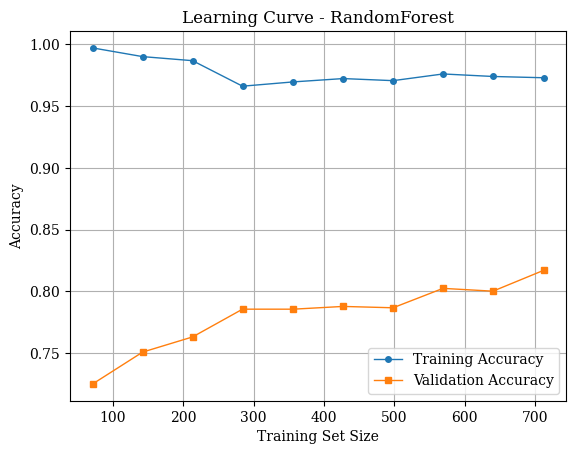

In [24]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=10, random_state=42)
learning_cuvre_plot(rf, X, y, ax=plt.gca(), title='RandomForest')

## Find The Best Model

In [ ]:
def find_best_model(X_train, X_test, y_train, y_test):

    models = [
        LogisticRegression(max_iter = 600, random_state = 42),
        RandomForestClassifier(random_state = 42),
        XGBClassifier(random_state = 42),
        GradientBoostingClassifier(random_state = 42),
        LGBMClassifier(random_state = 42, verbose=0),
        CatBoostClassifier(random_state = 42),
    ]

    model_names, scores = [], []

    for model in models:
        name = type(model).__name__
        print(f'MODEL {name} ...')

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc = round(accuracy_score(y_test, y_pred) * 100, 2)

        model_names.append(name)
        scores.append(acc)

    df_models = pd.DataFrame({'Model': model_names, 'Score': scores})
    print(df_models.sort_values('Score', ascending = False).reset_index(drop = True))

In [30]:
X = features_pipline.fit_transform(df_original)
y = df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
find_best_model(X_train, X_test, y_train, y_test)

hell
MODEL LogisticRegression ...
MODEL RandomForestClassifier ...
MODEL XGBClassifier ...
MODEL GradientBoostingClassifier ...
MODEL LGBMClassifier ...
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

## Grid Search On RandomForest

In [42]:
X = features_pipline.fit_transform(df_original)
y = df['Survived']

rf = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',     # or 'roc_auc'
    n_jobs=-1,
    verbose=2
)
grid_search.fit(X, y)

print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters: {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best score: 0.832772581758835


## XGboost

In [43]:
numeric_features = [
    'Age', 'SibSp', 'Parch', 'Fare', 'FamilySize'
    ]
categorical_features = [
    'Pclass', 'Sex', 'Embarked', 'Cabin_letter', 'Title',
    'IsAlone', 'TicketPrefix', 'IsSharedTicket'
    ]

features_pipline = get_features_piplines(numeric_features, categorical_features)

X = features_pipline.fit_transform(df_original)
y = df['Survived']

xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss',
                        random_state=42)

param_grid = {
    'n_estimators': [10, 50, 100, 200, 300, 500],
    'max_depth': [1, 2, 3, 5, 7, None],
    'learning_rate': [0.01, 0.1, 0.2, 0.3, 0.5],
    'subsample': [0.3, 0.5, 0.8, 1],
    'colsample_bytree': [0.3, 0.5, 0.8, 1]
}

grid_search = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',     # or 'roc_auc'
    n_jobs=-1,
    verbose=2
)
grid_search.fit(X, y)

Fitting 5 folds for each of 1600 candidates, totalling 8000 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:43:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.3, 0.5, 0.8, 1],
                         'learning_rate': [0.01, 0.1, 0.2, 0.3, 0.5],
                         'max_depth': [1, 2, 3, 5, 7],
                         'n_estimators': [10, 50, 100, 200],
                         'subsample': [0.3, 0.5, 0.8, 1]},
             scoring='accuracy', verbose=2)

### Feature Importances

Best parameters: {'colsample_bytree': 0.5, 'learning_rate': 0.3, 'max_depth': 2, 'n_estimators': 200, 'subsample': 0.8}
Best score: 0.847373046262005


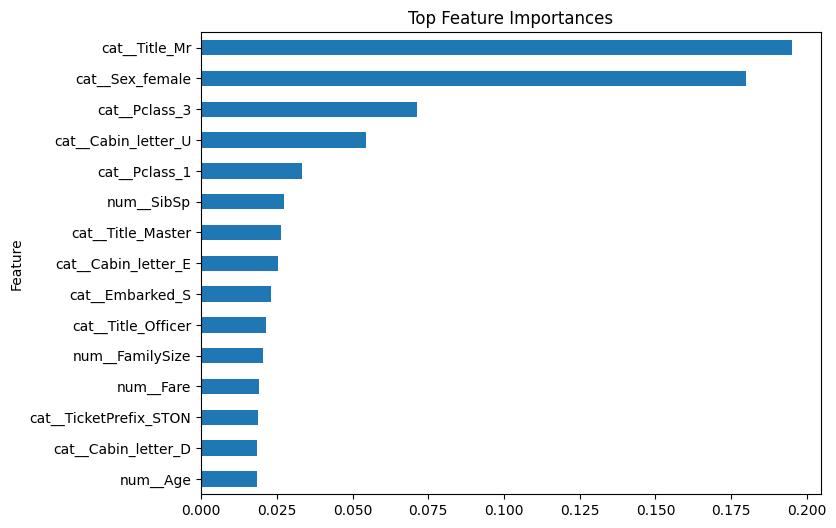

In [46]:
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

best_model = grid_search.best_estimator_
feature_importances = best_model.feature_importances_
feature_names = features_pipline.named_steps['columns'].get_feature_names_out()

# Combine
import pandas as pd
feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)


# plot feat_imp_df
feat_imp_df.head(15).plot(kind='barh', x='Feature', y='Importance',
                          figsize=(8, 6), legend=False)
plt.title('Top Feature Importances')
plt.gca().invert_yaxis()
plt.show()

### Model Evaluation

In [47]:
y_pred = best_model.predict(X)
print("Accuracy:", accuracy_score(y, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y, y_pred))
print("Classification Report:\n", classification_report(y, y_pred))

Accuracy: 0.9046015712682379
Confusion Matrix:
 [[522  27]
 [ 58 284]]
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.95      0.92       549
           1       0.91      0.83      0.87       342

    accuracy                           0.90       891
   macro avg       0.91      0.89      0.90       891
weighted avg       0.91      0.90      0.90       891



### Evaluation on Test Set

In [48]:
best_model = grid_search.best_estimator_

df_test = pd.read_csv('./test.csv')
X_test = features_pipline.transform(df_test)
y_pred = best_model.predict(X_test)

# Create a DataFrame with 'PassengerId' and 'Survived' columns
submission_df = pd.DataFrame({
    'PassengerId': df_test['PassengerId'],
    'Survived': y_pred
})

submission_df.to_csv('submission.csv', index=False)


NameError: name 'submission' is not defined